In [1]:
!pip install yfinance


[notice] A new release of pip available: 22.2.2 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
my_dpi = 120

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import copy
import numpy as np
from IPython.display import display
import yfinance as yf
import pandas_datareader
import math 
from sklearn import preprocessing
from tensorflow.python import metrics
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

In [3]:
def preprocess_ds(data,day_ago,target=False):
     x = []
     y = []
     for i in range(day_ago,len(data)):
          x.append(data[i-day_ago:i]) # historical data: (i-day_ago)~(i-1)
          y.append(data[i,0]) # current observation: i
     if target: 
        x.append(data[len(data)-day_ago:])
     return (np.array(x),np.array(y))

In [4]:
def preprocess_package(stock_df,day_ago = 50,feature_lst = ["Close","Volume"]):

  # Normalization 
  feature_normalizer = preprocessing.MinMaxScaler()
  normalized_df = feature_normalizer.fit_transform(stock_df[feature_lst])
  target_normalizer = preprocessing.MinMaxScaler() # use this to transfer prediction back 
  target_normalizer.fit(stock_df[["Close"]]) 

  # train-test split
  train_split = 0.8
  split_pt = math.ceil(len(normalized_df) * train_split)

  train_set = normalized_df[:split_pt]
  test_set = normalized_df[split_pt:]

  # preprocess
  train_x , train_y = preprocess_ds(train_set,day_ago=day_ago,target=False)
  test_x, test_y = preprocess_ds(test_set,day_ago=day_ago,target=True)
  
  return (train_x, train_y, test_x, test_y, target_normalizer)

In [5]:
def gimme_LSTM_model(day_ago=50,num_feature=2):
  keras.backend.clear_session()

  model = keras.Sequential()
  model.add(layers.LSTM(150,input_shape=(day_ago,num_feature),return_sequences=True))
  model.add(layers.LSTM(100))
  model.add(layers.Dense(30,activation="relu"))
  model.add(layers.Dense(1))

  model.compile(loss="mean_squared_error",
            optimizer="adam")
  
  return model

In [6]:
def LSTM_for_list_stock(stock_list,day_ago=50):
  feature_lst = ["Close","Volume"]
  result_dic = {}
  batch_size = 1
  epochs = 3
  num_feature = len(feature_lst)

  for i in stock_list:
    # preprocess
    stock_df =yf.download(i,period="10y")
    train_x, train_y, test_x, test_y, target_normalizer = preprocess_package(stock_df,day_ago=50)
    # model 
    model = gimme_LSTM_model(day_ago=50,num_feature=num_feature)
    model.fit(train_x,train_y,epochs=epochs,batch_size=batch_size)
    
    # predict
    pred_y = model.predict(test_x)
    y_pred_price = target_normalizer.inverse_transform(pred_y)

    # result
    original = list(stock_df["Close"][len(stock_df)-len(y_pred_price)+1:])
    original.append(None)
   
    result_df = pd.DataFrame(data={"original":original,"pred":list(y_pred_price .reshape(1,len(y_pred_price ))[0])})
    result_dic[i] = result_df
    
  return result_dic

# Static input for model

In [7]:
stock_list=["AAPL","IBM","GOOGL","META","JPM"]
result = LSTM_for_list_stock(stock_list)

[*********************100%***********************]  1 of 1 completed
Epoch 1/3
1965/1965 [==============================] - 41s 19ms/step - loss: 8.1345e-04
Epoch 2/3
1965/1965 [==============================] - 36s 18ms/step - loss: 3.9648e-04
Epoch 3/3
15/15 [==============================] - 3s 30ms/step
[*********************100%***********************]  1 of 1 completed
Epoch 1/3
1965/1965 [==============================] - 50s 23ms/step - loss: 0.0027
Epoch 2/3
1965/1965 [==============================] - 41s 21ms/step - loss: 8.6690e-04
Epoch 3/3
15/15 [==============================] - 1s 18ms/step
[*********************100%***********************]  1 of 1 completed
Epoch 1/3
1965/1965 [==============================] - 42s 20ms/step - loss: 5.8027e-04
Epoch 2/3
1965/1965 [==============================] - 39s 20ms/step - loss: 2.0307e-04
Epoch 3/3
15/15 [==============================] - 1s 22ms/step
[*********************100%***********************]  1 of 1 completed
Epoch 1/

## Output is a DICTIONARY with symbol name as key and predicted result (dataframe) as values
For instance,

In [8]:
result["AAPL"]

,original,pred
0,125.349998,116.289032
1,120.989998,115.834465
2,121.260002,113.845757
3,127.790001,112.676071
4,125.120003,114.925919
...,...,...
449,146.630005,132.295517
450,142.910004,131.925690
451,140.940002,130.228699
452,142.649994,128.481430


In [9]:
result.keys()

dict_keys(['AAPL', 'IBM', 'GOOGL', 'META', 'JPM'])

## Visualization (input is simply that DICTIONARY)

In [14]:
def visualize_LSTM(result):
  for sym,df in result.items():
    plt.plot(df["pred"],label="pred")
    plt.plot(df["original"],label="test")
    up_or_down = "up" if (np.sign(df["pred"][len(df)-1] - df["pred"][len(df)-2]) == 1) else "down" 

    plt.scatter(len(df)-1,df["pred"][len(df)-1],c="r",s=5,label=up_or_down)
    plt.title(sym)
    plt.legend()
    plt.savefig(f'..\static\{sym}_viz.png', dpi=100)
    plt.show()

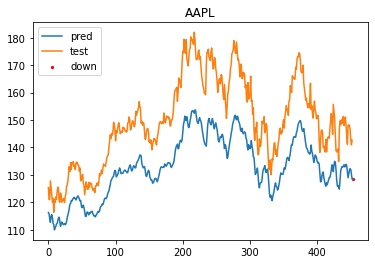

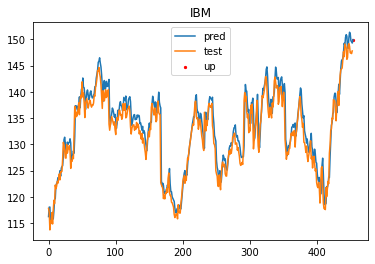

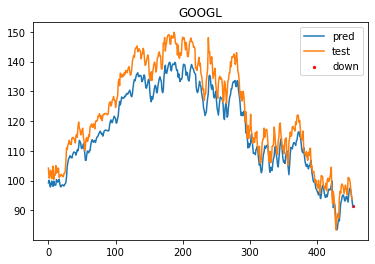

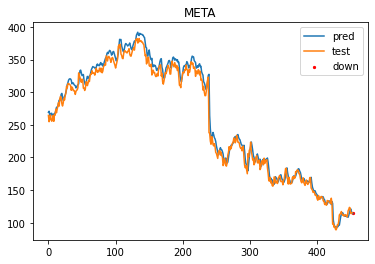

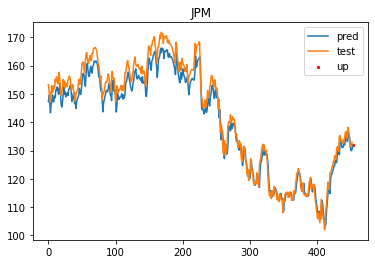

In [13]:
visualize_LSTM(result)